[View in Colaboratory](https://colab.research.google.com/github/JoaoCarabetta/isometric/blob/master/isometric.ipynb)

# Make sure that the section is running on Python 3
Runtime >> Change Runtime Type >> Runtime Type = Python3

# Setup == Run this every time you use!

In [0]:
!pip3 install osmnx
!pip3 install networkx

!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip3 install rtree
!ldconfig

import networkx as nx
from google.colab import files

from pylab import rcParams
rcParams['figure.figsize'] = 12, 20

import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)

import ast
from copy import deepcopy
from collections import defaultdict
from shapely.ops import cascaded_union
from shapely.geometry import mapping, Polygon
import fiona
from tqdm import tqdm

# Code == Run this too!

In [0]:
def string_to_list(string):
    
    return ast.literal_eval('[' + string + ']')

def strings_to_list(*args):
        
    return list(map(string_to_list, args))

def download_graph(coordinates, distances):
    
    max_distance = max(distances)
    
    G = False
    for coordinate in tqdm(coordinates, desc='Downloading'):

        if G:

            G = nx.compose(deepcopy(G), ox.graph_from_point(coordinate, 
                                                  distance=max_distance,
                                                  network_type='walk'))
        else:
            G = ox.graph_from_point(coordinate, distance=max_distance, network_type='walk')            
    
    return G


def make_iso_polys(G, coordinate, distances, center_nodes,
                   edge_buff=25, node_buff=0, infill=True):
    
    
    isochrone_polys = {}
    for trip_time in tqdm(sorted(distances, reverse=True), desc='Calculating Isometric'):
        isochrone_polys[trip_time] = {}
        polygons = []
        for center_node, coor in zip(center_nodes, coordinates):
        
           
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, 
                                    distance='length')

            node_points = [Point((data['x'], data['y'])) 
                           for node, data in subgraph.nodes(data=True)]
            
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()},
                                         geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lines.append(LineString([f,t]))

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union

            # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
            if infill:
                new_iso = Polygon(new_iso.exterior)
            polygons.append(new_iso)
            
        isochrone_polys[trip_time] = cascaded_union(polygons)

    return isochrone_polys


def plot(G, isochrone_polys, center_nodes, distances):
    
    nc = ['blue' if node in center_nodes else 'none' for node in G.nodes()]
    ns = [20 if node in center_nodes else 0 for node in G.nodes()]
    
    iso_colors = ox.get_colors(n=len(distances), cmap='Reds', 
                               start=0.3, return_hex=True)
    
    # plot the network then add isochrones as colored descartes polygon patches
    fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, 
                             edge_color='k', edge_alpha=0.2, node_color=nc,
                           node_size=ns)
    
    for dist, poly in tqdm(isochrone_polys.items(), desc='Plotting'):
        patch = PolygonPatch(poly, fc='red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    plt.show()

def export(polygons):
    
    for distance, polygon in polygons.items():
        
        filename = 'distance-{}.shp'.format(distance) 

        # Define a polygon feature geometry with one attribute
        schema = {
            'geometry': 'Polygon',
            'properties': {'distance': 'int'},
        }

        # Write a new Shapefile
        with fiona.open(filename, 'w', 'ESRI Shapefile', schema) as c:
            ## If there are multiple geometries, put the "for" loop here
            c.write({
                'geometry': mapping(polygon),
                'properties': {'distance': distance},
            })

        files.download(filename)

def main(coordinates, distances):
    
    # Convert string to list
    coordinates, distances = strings_to_list(coordinates, distances)
    
    # Download Graph
    G = download_graph(coordinates, distances)
    
    # Get central nodes
    center_nodes = [ox.get_nearest_node(G, coor)
                    for coor in coordinates]
    
    # Project Graph
    G = ox.project_graph(G)
    
    # Get polygons
    isochrone_polys = make_iso_polys(G, coordinates, distances, center_nodes)
    
    # Plot
    plot(G, isochrone_polys, center_nodes, distances)

    # Export
    export(isochrone_polys)
    

### How to input
coordinates: (-22.94,-43.18), (-22.96,-43.21) :: (lat, long), (lat, long) as a string

distances: 200, 500, 1000 :: distance as string

Plotting: 100%|██████████| 1/1 [00:00<00:00, 238.12it/s]


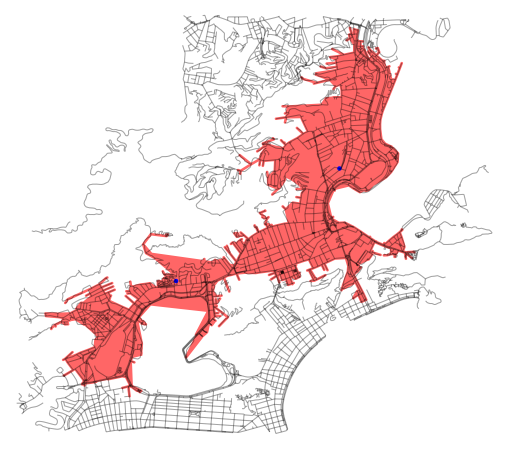

In [97]:
#@title Input
coordinates = "(-22.94,-43.18), (-22.96,-43.21)" #@param {type:"string"}
distances = "3000" #@param {type:"string"}
save_as = "shp" #@param ["shp", "geojson"]

poly = main(coordinates, distances)
